# Star Type Classification

Classifying the star type of an unclassifed star using its absolute temperature and absolute magnitude

# Part I: Introduction

There are many different types of stars that exist in our universe, and they can be classified into different categories. Grouping stars of similar characteristics allows individuals from astronomers to the general public to glean the general characteristics of a star, such as age, magnitude, or origin, simply by knowing its "star type." For our project we will consider two specific characteristics of stars, use them to classify the star type of an unclassified star, and determine how accurately these two characteristics can be used to predict star type. A high accuracy would indicate that these characteristics have unique ranges corresponding to different star types, thus they can be used as indications of star type.

To obtain data on stars, we will be using the “Star dataset to predict star types” dataset from Kaggle, which consists of data for 240 observations (240 stars). The characteristics, or variables, recorded are indicated along with the units of measurement as follows:
- Absolute Temperature (Kelvin)
- Relative Luminosity (L/Lo)
- Relative Radius (R/Ro)
- Absolute Magnitude (Mv)
    {note: Mv= m - 2.5log[(d/10)^2]}
- Star color (white, red, blue, etc.)
- Spectral class (O, B, A etc.)

The 6 different star types considered in this data set are given a generic numerical value for ease of use in classification and are as follows:
- Brown Dwarf (star type = 0)
- Red Dwarf (star type = 1)
- White Dwarf (star type = 2)
- Main sequence (star type = 3)
- Supergiant (star type = 4)
- Hypergiant (star type = 5)

For the purpose of our classification, we will only be using **Absolute Temperature (K)** and **Absolute Magnitude (Mv)** to predict the **Star Type** of an unclassified star, guided by the question: “can we create a classifier that can accurately classify the Star Type of an unclassified star?” All other variables will be removed from the data set before we begin our classification.

# Part II: Preliminary exploratory data analysis

- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- **Using only training data**, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- **Using only training data**, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.


In [20]:
# delete above cell once done

To begin, we created a Jupyter Notebook and attached all of the packages that we would need for our classification. We also set a random seed so we would not risk forgetting it later.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
library(kknn)

set.seed(777)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Next, we loaded the dataset from Kaggle into our notebook. The original column names had spaces, so we changed the names into a more usable format. Additionally, the star type column was of the wrong data type so we converted it into data type "factor". Finally, we selected only the columns that we are interested in for our classification (absolute temperature, absolute magnitude, and star type). The data is now in a tidy format and ready for use in classifcation.

To give a sense of how the data looks now, we have shown the first 6 and last 6 rows.
    
{note: the dataset has 240 observations, so there are 240 rows. Additionally, the data is currently organised in order of increasing star type (0-6).}

In [2]:
raw_data <- read_csv("https://raw.githubusercontent.com/uchou92/dcsi-100-2023w1-group-28/main/6_class_csv%5B1%5D.csv", col_names=FALSE,
             skip=1)

colnames(raw_data) <- c("abs_temperature", "luminosity", "radius", "abs_magnitude", "star_type", "star_color", "spectral_class")

star_data <- raw_data|>
        mutate(star_type = as_factor(star_type))|>
        mutate(star_type = fct_recode(star_type, "star_type" = "star_type"))|>
        select(abs_magnitude, star_type, abs_temperature)

head(star_data) 
tail(star_data)

Rows: 240 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): X6, X7
dbl (5): X1, X2, X3, X4, X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `star_type = fct_recode(star_type, star_type = "star_type")`.
Caused by warning:
! Unknown levels in `f`: star_type”


abs_magnitude,star_type,abs_temperature
<dbl>,<fct>,<dbl>
16.12,0,3068
16.60,0,3042
18.70,0,2600
16.65,0,2800
20.06,0,1939
16.98,0,2840


abs_magnitude,star_type,abs_temperature
<dbl>,<fct>,<dbl>
-7.67,5,21904
-9.93,5,38940
-10.63,5,30839
-10.73,5,8829
-11.23,5,9235
-7.80,5,37882


We can also see how absolute temperature and absolute magnitude are related with respect to star type. Already it is possible to see that the different star types are grouped in different regions on the plot, indicating that we should have some success with our classifier.

{note: this data is unstandardized and axes not to scale}

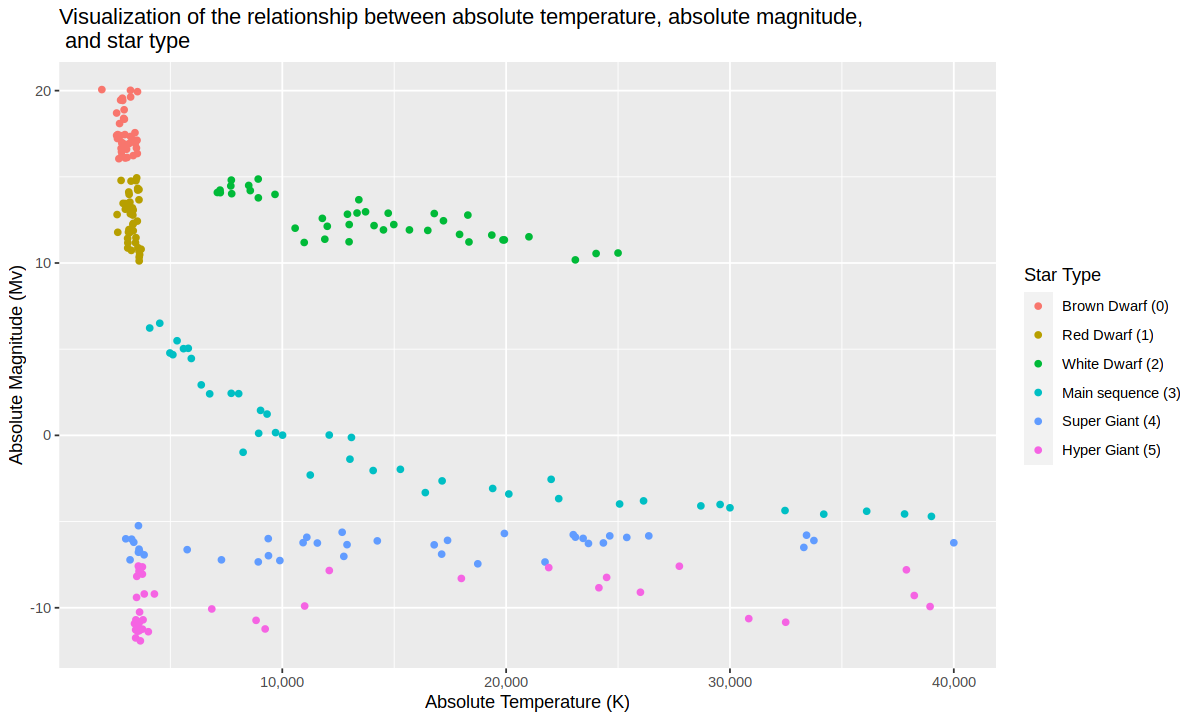

In [61]:
summary_plot <- star_data |>
    ggplot(aes(x = abs_temperature, y = abs_magnitude, color = star_type))+
            geom_point()+
            scale_color_hue(labels = c("Brown Dwarf (0)", "Red Dwarf (1)", "White Dwarf (2)","Main sequence (3)", 
                                       "Super Giant (4)", "Hyper Giant (5)")) +
            labs(x = "Absolute Temperature (K)", y = "Absolute Magnitude (Mv)", color = "Star Type") +
            ggtitle("Visualization of the relationship between absolute temperature, absolute magnitude, \n and star type") +
            scale_x_continuous(labels = scales::comma_format())    
summary_plot

options(repr.plot.width = 10, repr.plot.height = 6)

The first step to beginning our classification is to separate our data into a training set and a testing set. We used a 75% training-testing split, and stratified by star type so as to avoid class imbalance in either the testing or training data sets.

In [3]:
data_split <- star_data |>
            initial_split(prop = 0.75, strata = star_type)

data_training <- training(data_split)
data_testing <- testing(data_split)

To give an overview of what our training set looks like now that it is ready for use in classification, we have summarised how many of each star type is present in the training set. Since we know there were 240 original observations, we should have 75% so 30 observations of each star type in our training set. If we don't, then we know we have some missing data.

{note: there is no missing data!}

In [4]:
summary_training <- data_training |>
                    group_by(star_type) |>
                    summarize(count = n()) |>
                    arrange(desc(count))
summary_training

star_type,count
<fct>,<int>
0,30
1,30
2,30
3,30
4,30
5,30


# Part III: Classification

We will be performing classification using the K-nearest neighbours algorithm to classify star type using absolute temperature and absolute magnitude. First, we will tune for K so we know how many neighbours to consider. 

## Tuning for K

To begin tuning, we created a recipe with the training data. Since our data only contains our two predictor variables (absolute temperature and absolute magnitude) and our response variable (star type), we can simply set our recipe to predict star type using all variables (denoted '~.'). We want to standardize both predictor variables by scaling and centering about a mean of 0 and standard deviation of 1, so as to ensure all data is on a comparable scale and contributes equally to K-nearest distance calculations performed by the algorithm.

In [ ]:
star_recipe <- recipe(star_type ~., data_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

To determine the best value for K, we need to perform cross-validation, essentially splitting the training data into a new training and testing set and testing for different K-values to determine the value with the highest accuracy. We will use 5-fold cross validation and stratify by star type again.

In [32]:
star_vfold <- vfold_cv(data_training, v = 5, strata = star_type)

We have chosen to test K-values ranging from 1 to 5, because this is the most commonly suitable range.

In [34]:
kvals <- tibble(neighbors = seq(from = 1, to = 5))

In order to tune the algorithm, we pass the 'tune()' argument to the nearest_neighbor function and give the specifications. We will use the 'kknn' engine, classification mode, and weigh_func = "rectangular" so that the algorithm uses the straight line distance between observations when determine nearest neighbours.

In [ ]:
star_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

Finally, we combine everything into a workflow and can test the different K-values.

In [36]:
star_workflow <- workflow() |>
                    add_recipe(star_recipe) |>
                    add_model(star_spec) |>
                    tune_grid(resamples = star_vfold, grid = kvals)

Now, we can collect our results and see which K-value had the highest accuracy. To better visualise the varying degrees of accuracy, we also plotted a graph of K-value (on the x-axis) vs. accuracy (on the y-axis).

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9333333,5,0.02078699,Preprocessor1_Model1
2,accuracy,multiclass,0.9333333,5,0.02078699,Preprocessor1_Model2
3,accuracy,multiclass,0.9055556,5,0.02859897,Preprocessor1_Model3
4,accuracy,multiclass,0.8944444,5,0.02693155,Preprocessor1_Model4
5,accuracy,multiclass,0.8611111,5,0.02324056,Preprocessor1_Model5


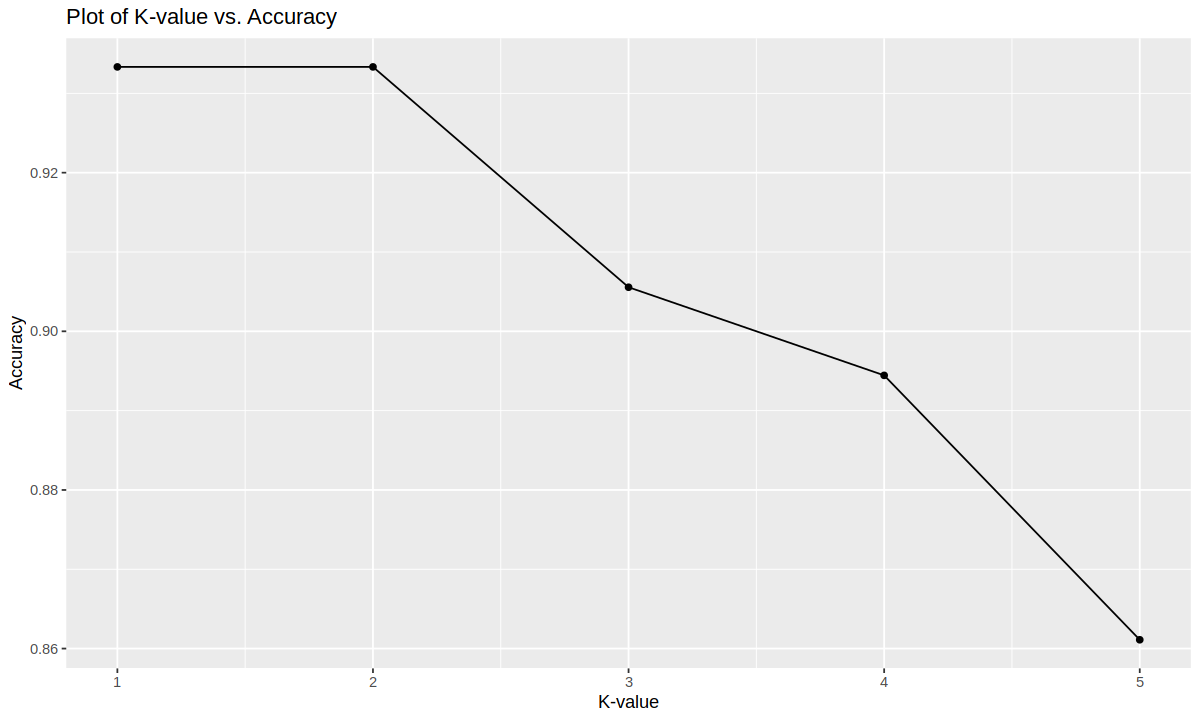

In [39]:
star_results <- star_workflow |> 
                    collect_metrics() |>
                    filter(.metric == "accuracy")
star_results

star_plot <- star_results |> 
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K-value", y = "Accuracy")+
                ggtitle("Plot of K-value vs. Accuracy")
star_plot

As you can see from both the table and the graph, the accuracy for K = 1 and K = 2 is the same at 95% and is the highest degree of accuracy. We have chosen to use K = 2 to avoid over-fitting our data, since our training set may not completely reflect the whole data set.

In [41]:
#add explanation of why K=2 above

## Classifying an unlabelled star using our model

In [42]:
#the star we chose, why, and the code for its abs mag and abs temp values

In [12]:
polaris <- tibble(abs_magnitude= -3.64, abs_temperature= 7200)
polaris

abs_magnitude,abs_temperature
<dbl>,<dbl>
-3.64,7200


In [13]:
polaris_prediction <-predict(star_fit, polaris)
polaris_prediction

.pred_class
<fct>
3


## Measuring the accuracy of our classifier

Another, more quantitative, method of measuring the accuracy of our classifier is by analysing its accuracy with the testing set. Since we tuned the classifier using the training set, we can use the classifier to predict all of the star types of the observations in the testing set, then compare the prediction with the true value and see how our classifier did.

First, we recreate the specifications for the algorithm with our chosen K-value of 2. Then, we combine this new specification with the recipe we created earlier and fit it to the training data.

In [43]:
star_main_spec <- nearest_neighbor(weight_func = "rectangular", n = 2 ) |>
                set_engine("kknn") |> 
                set_mode("classification")

star_fit <- workflow() |>
            add_recipe(star_recipe) |> 
            add_model(star_main_spec) |>
            fit(data_training)

Next, we use the algorithm to predict the star types of the testing set. We use the bind_cols function to add the predicted class directly to our data set so we can easily compare the predicted and actual class. The first 6 predictions are shown for reference.

In [51]:
star_predictions <- star_fit |>
                     predict(data_testing) |>
                     bind_cols(data_testing)
head(star_predictions)

.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
0,18.70,0,2600
1,10.48,1,3628
2,11.89,2,16500
2,14.20,2,8570
2,14.47,2,7700
2,14.08,2,7230


So far, it looks like our classifier has perfect accuracy. To easily see how the classifier does for all observations in the testing set without looking through 60 rows of data, we can compute the confusion matrix which tells us how many predictions were made for each star type and how it compares with the 'truth' - the actual star type.

{note: since the testing set was 25% of the original 240 observations, it contains 60 observations: 10 of each star type}

In [49]:
star_matrix <- conf_mat(star_predictions, truth = star_type, estimate = .pred_class)
star_matrix

          Truth
Prediction  0  1  2  3  4  5
         0 10  0  0  0  0  0
         1  0 10  0  0  0  0
         2  0  0 10  0  0  0
         3  0  0  0  8  0  0
         4  0  0  0  2  9  0
         5  0  0  0  0  1 10

From the confusion matrix, it seems our classifier only made 3 mistakes: twice, the classifier predicted a star was of star type 4 (Supergiant) when it was actually when it was actually star type 3 (Main Sequence), and predicted one star was of star type 5 (Hypergiant) when it was actually of star type 4 (Supergiant). 3 mistakes out of 60 predictions is pretty accurate! We can also compute the accuracy using the metrics function and filtering for accuracy:

In [9]:
star_metrics <- star_predictions |>
                metrics(truth = star_type, estimate = .pred_class) |>
                filter(.metric == "accuracy")
star_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.95


Our classifier is then 95% accurate! We can also revisit the plot of absolute temperature vs. absolute magnitude to try and see where our classifier struggled. First we need to determine the absolute magnitude and absolute temperature of these 3 stars:

In [56]:
star_mistakes1 <- star_predictions |>
                filter(star_type == "3", .pred_class == "4")
star_mistakes1

star_mistakes2 <- star_predictions |>
                filter(star_type == "4", .pred_class == "5")
star_mistakes2

.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
4,-3.32,3,16390
4,-4.57,3,34190


.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
5,-7.346,4,21738


Now we can annotate the graph to see just where it exactly these stars lie relative to the others:

In [ ]:
mistakes_plot <- star_data |>
    ggplot(aes(x = abs_temperature, y = abs_magnitude, color = star_type))+
            geom_point()+
            scale_color_hue(labels = c("Brown Dwarf (0)", "Red Dwarf (1)", "White Dwarf (2)","Main sequence (3)", 
                                       "Super Giant (4)", "Hyper Giant (5)")) +
            labs(x = "Absolute Temperature (K)", y = "Absolute Magnitude (Mv)", color = "Star Type") +
            ggtitle("Visualization of the relationship between absolute temperature, absolute magnitude, \n and star type") +
            scale_x_continuous(labels = scales::comma_format())    

# Part IV: Discussion

In [40]:
#so this is just significance, etc.

- We are expecting to successfully find the star type (6 classes ranging from 0-5) based on Temperature (K) and Absolute Magnitude(Mv) of a single unclassified point. 

- These findings could impact users who are not familiar with stars to easily identify those star types based on these characteristics. 

- Some future questions that this could lead to are what other variables can impact the classification of star types apart from absolute temperature and magnitude? Are there any exceptions to the identification of Star types that can occur due to these other variables? How can classification help us in the Astronomy in the real-world workplace such as NASA?


# Part V: References